In [45]:
%%html
<img src="imgs/orientation.jpg" width="50%">
camera organization & lidar(velo) setup

In [46]:
%%html
<img src="imgs/car.png" width="50%">

In [47]:
%%html
Intrinsic matrix: K
<img src="imgs/intrinsic.jpg" width="18%">
[Rotational matrix , Extrinsic matrix]: [R , T]
<img src="imgs/whole.jpg" width="20%">
Velodyne Point Cloud coords to camera
<img src="imgs/pt_to_cam.jpg" width="19%">

intrinsic matrix(obtained by camera calibration)：calib.P_rect{cam+1}
rotational matrix based on cam0：R_cam_to_rect
extrinisc：Tr_velo_to_cam

P_velo_to_img = calib.P_rect{cam+1} * R_cam_to_rect * Tr_velo_to_cam

In [48]:
import mayavi.mlab as mlab
import matplotlib.pyplot as plt
from utils.coord_transform import *
from utils.file_load import *

import torch.backends.cudnn
import numpy as np
from glob import glob
import sys
import os
import cv2
import yaml

yamlPath = "configure.yaml"
f = open(yamlPath, 'r', encoding='utf-8')

conf = f.read()
conf_dict = yaml.safe_load(conf) 

range_x=conf_dict['range_x']
range_y=conf_dict['range_y']
range_z=conf_dict['range_z']
vox_depth = conf_dict['vox_d']
vox_width = conf_dict['vox_w']
vox_height = conf_dict['vox_h']
classes = conf_dict["classes"]

print (classes)
parent_pth = "/Users/syd/Documents/GitHub/VoxelNet-pytorch/data/dataset/voxel_mini_data"
velo_parent_path = os.path.join(parent_pth,"data_object_velodyne/")

velo_files = glob(velo_parent_path+'*/velodyne/*')

# NUMBER 2 is the origin of camera coordinate
CAM = 2


['Car', 'Cyclist', 'Van', 'Pedestrian']


In [53]:
def plot_bbox_2d(file_index):
    file_name = "%06d"%(file_index)
    img_path = os.path.join(parent_pth,'data_object_image_2','training','image_2',file_name+'.png')
    label_path = os.path.join(parent_pth,'data_object_label_2','training','label_2',file_name+'.txt')
    print(file_index,img_path)
    bbox_2d, bbox_3d= read_label(label_path)
    img = read_img(img_path)
    img_height,img_width,_ = img.shape
    plt.figure(figsize=(30,30))
    for box in bbox_2d:
        cur_type = box[0]
        cur_conf = box[-1]
        box = list(map(lambda x: int(eval(x)),box[1:-1]))
        if cur_type not in classes:
            continue
       
        xmin = max(min(box[0],box[2]),0)
        xmax = min(max(box[0],box[2]),img_width)
        ymin = max(min(box[1],box[3]),0)
        ymax = min(max(box[1],box[3]),img_height)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, cur_type, (xmin, ymin), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
    plt.imshow(img)

73 /Users/syd/Documents/GitHub/VoxelNet-pytorch/data/dataset/voxel_mini_data/data_object_image_2/training/image_2/000073.png


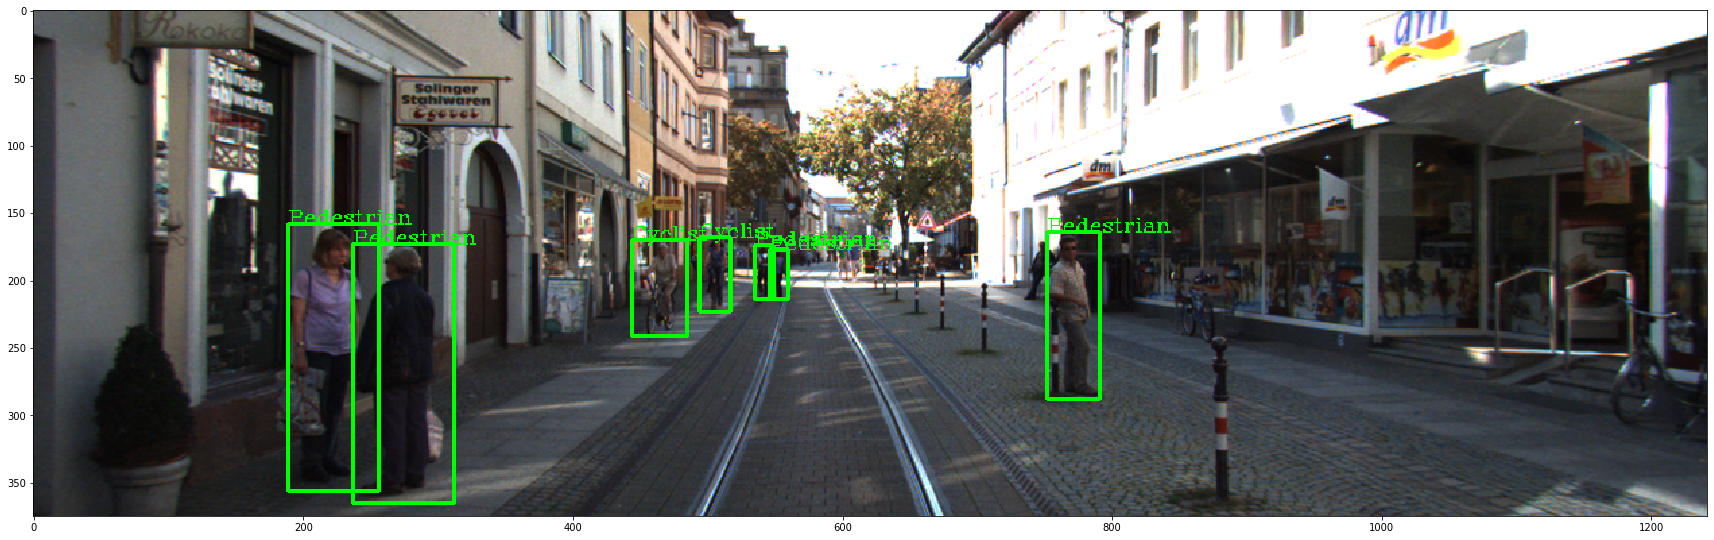

In [54]:
index = 73
plot_bbox_2d(index)

In [51]:
def draw_lidar(lidar, is_grid=False, is_axis = False, is_top_region=True, fig=None):
    pxs=lidar[:,0]
    pys=lidar[:,1]
    pzs=lidar[:,2]
    prs=lidar[:,3]
    
    if fig is None: fig = mlab.figure(figure=None, bgcolor=(0,0,0), fgcolor=None, engine=None, size=(1000, 500))
   
    mlab.points3d(
        pxs, pys, pzs, prs,
        mode='point',  # 'point'  'sphere'
        colormap='gnuplot',  #'bone',  #'spectral',  #'copper',
        scale_factor=1,
        figure=fig)
   
    #draw grid
    if is_grid:
        mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2,figure=fig)

        for y in np.arange(-50,50,1):
            x1,y1,z1 = -50, y, 0
            x2,y2,z2 =  50, y, 0
            mlab.plot3d([x1, x2], [y1, y2], [z1,z2], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)

        for x in np.arange(-50,50,1):
            x1,y1,z1 = x,-50, 0
            x2,y2,z2 = x, 50, 0
            mlab.plot3d([x1, x2], [y1, y2], [z1,z2], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)

    #draw axis
    if is_axis:
        mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2,figure=fig)

        axes=np.array([
            [2.,0.,0.,0.],
            [0.,2.,0.,0.],
            [0.,0.,2.,0.],
        ],dtype=np.float64)
        fov=np.array([  ##<todo> : now is 45 deg. use actual setting later ...
            [20., 20., 0.,0.],
            [20.,-20., 0.,0.],
        ],dtype=np.float64)

        mlab.plot3d([0, axes[0,0]], [0, axes[0,1]], [0, axes[0,2]], color=(1,0,0), tube_radius=None, figure=fig)
        mlab.plot3d([0, axes[1,0]], [0, axes[1,1]], [0, axes[1,2]], color=(0,1,0), tube_radius=None, figure=fig)
        mlab.plot3d([0, axes[2,0]], [0, axes[2,1]], [0, axes[2,2]], color=(0,0,1), tube_radius=None, figure=fig)
        mlab.plot3d([0, fov[0,0]], [0, fov[0,1]], [0, fov[0,2]], color=(1,1,1), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([0, fov[1,0]], [0, fov[1,1]], [0, fov[1,2]], color=(1,1,1), tube_radius=None, line_width=1, figure=fig)

    #draw top_image feature area
    
    if is_top_region:
        x1 = cfg.xrange[0]
        x2 = cfg.xrange[1]
        y1 = cfg.yrange[0]
        y2 = cfg.yrange[1]
        
        mlab.plot3d([x1, x1], [y1, y2], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([x2, x2], [y1, y2], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([x1, x2], [y1, y1], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([x1, x2], [y2, y2], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)

    mlab.orientation_axes()
    mlab.view(azimuth=180,elevation=None,distance=50,focalpoint=[ 12.0909996 , -1.04700089, -2.03249991])#2.0909996 , -1.04700089, -2.03249991
    #out_path ="imgs/lidar.jpg"
    #mlab.savefig(out_path)
    return fig


In [52]:
#visualization of all pt cloud
lidars = read_velodyne_points(velo_files[index])
lidars,indices = prepare_velodyne_points(lidars,range_x =range_x,range_y=range_y,range_z = range_z)
fig = draw_lidar(lidars,is_grid = False,is_axis = False,is_top_region = False)

IndexError: list index out of range

In [27]:
def plot_bbox3d(lidars,bbox3d, cal_Tr, fig, color_setting='uniform', line_width=2):
    colors = [(0,0,1),(0,1,0),(1,0,0),(0,1,1),(1,0,1),(1,1,1)]
    for b in bbox3d:
        if b[0] not in classes:
            continue
        if color_setting== 'uniform':
            color = (1,0,1)
        else:
            color = colors[classes.index(b[0])]
        b = list(map(lambda x:eval(x),b[1:]))
        b = box3d_cam_to_velo(b,cal_Tr)
        #print(b)
        for k in range(0,4):
            i,j=k,(k+1)%4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
            i,j=k+4,(k+3)%4 + 4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
            i,j=k,k+4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
    mlab.view(azimuth=180,elevation=None,distance=50,focalpoint=[ 12.0909996 , -1.04700089, -2.03249991])#2.0909996 , -1.04700089, -2.03249991
    out_path ="imgs/lidar.jpg"
    mlab.savefig(out_path)
    mlab.close()

In [28]:
#visualization of 3d-bbox
img_path,vel_path,cal_path,label_path = generate_file_path(index)
lidars = read_velodyne_points(vel_path)
lidars,indices = prepare_velodyne_points(lidars,range_x =range_x,range_y=range_y,range_z = range_z)
cal_dict = read_cal(cal_path)
fig = draw_lidar(lidars, is_grid=False, is_axis = False,is_top_region=False, fig=None)
_, bbox3d = read_label(label_path)

#print(bbox3d)
plot_bbox3d(lidars,bbox3d,cal_dict['Tr_velo_to_cam'],fig,color_setting='distinguished')

./data/dataset/voxel_mini_data
range [0, 70] [-40, 40] [-3, 1] 123478 123478


In [39]:
%%html
<img src="imgs/lidar.jpg" width="50%">
bboxes 3d in lidar pt cloud

In [44]:
a=np.array([[1,2,3],[2,3,1],[1,2,3],[4,5,6]])
np.unique(a,axis=0,return_inverse=True, return_counts=True)

(array([[1, 2, 3],
        [2, 3, 1],
        [4, 5, 6]]), array([0, 1, 0, 2]), array([2, 1, 1]))